In [1]:
import pandas as pd
import glob
import sys
import polars as pl
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.metrics import cohen_kappa_score
from utils_iaa import analyze_all_cases, analyze_cases, process_annotations_and_disagreements, compute_oa, cohen_kappa_pairs, compute_cohen_kappa_all_combinations, get_lists_from_columns, compute_observed_agreement_combinations

# Linguistic Synesthesia - yes or no? 
# Computing IAA before and after backtranslations and Visualizations

## Computing IAA

In [3]:
#reading the files
backtranslations_annotations = {} #creating a df for each annotated file with translated with LLM
for filename in glob.glob("./data/backtranslations/all_annotators*"):
    name = filename.split('/')[-1].split('.')[0].split('annotators_')[-1] #name of the df of each file
    print(name)
    backtranslations_annotations[name] = pd.read_csv(filename, sep=",")

DE_gpt
DE_google
ES_gpt
ES_google
DE_deepL
ES_deepL


In [4]:
backtranslations_annotations['ES_gpt'].head()

,instance,R,H,A,annotator-llm
0,A bored head among windy spaces.,No,No,No,no
1,A fine and pedantic sun with a satin vest.,No,No,No,yes
2,A silence permeates the story and a softness t...,Yes,No,No,yes
3,And painful must be the storm,Yes,No,No,no
4,"But through the pale, thin water, the harmless...",No,No,No,yes


## Computing IAA of human annotators before and after backtranslations

In [5]:
annotations = {}
# Iterating over each key and its df
for name, df in backtranslations_annotations.items():
    data = pl.DataFrame(df)  # converting to polars df

    # initializing a list to store columns for the current key
    columns_dict = {'instance': data['instance'].to_list()}

    # iterating over each column of annotators - so except the 'instance' column
    for column in data.columns[1:]:
        # skipping columns that contain 'llm' in their name - only computing human annotators
        if 'llm' not in column:
            # add both 'after-bt' and 'before-bt' columns to the dictionary
            columns_dict[f"{column}-after-bt"] = data[column].str.to_lowercase().to_list()
            columns_dict[f"{column}-before-bt"] = ['yes'] * data.height  # original values before BT
    
    # convert the columns dictionary to a pandas df and add it to the annotations dictionary
    annotations[name] = pd.DataFrame(columns_dict)

# combine all dfs into a single df
annotations_df = pd.concat(annotations.values(), keys=annotations.keys()).reset_index(level=0).rename(columns={'level_0': 'index'}).drop('instance', axis=1)


In [6]:
columns = [col for col in annotations_df.columns if col != 'index']
lang_llm = set(annotations_df['index'])

# dictionary to store DataFrames for each llm
dfs_per_llm = {}

# iterating over the unique index values
for llm in lang_llm:
    # filter the df for the current llm
    filtered_df = annotations_df[annotations_df['index'] == llm]
    # store the filtered df in the dictionary
    dfs_per_llm[llm] = filtered_df

In [7]:
# dictionary to store results
oa_matrices = {}
oa_aggregated = {}

for name, df in dfs_per_llm.items():
    print(f'IAA - {name}')
    list_of_annotations = get_lists_from_columns(df, columns)
    oa_results = compute_observed_agreement_combinations(list_of_annotations, columns)
    iaa_observed_agreement = compute_oa(list_of_annotations)
    # create an empty matrix with NaN values to be populated with IAA later
    oa_matrix = pd.DataFrame(np.nan, index=columns, columns=columns)
    
    for ann1, ann2, kappa in oa_results:

        oa_matrix.at[ann1, ann2] = kappa
        oa_matrix.at[ann2, ann1] = kappa 
    
    oa_matrices[name] = oa_matrix
    oa_aggregated[name] = iaa_observed_agreement

IAA - ES_deepL
IAA - DE_deepL
IAA - ES_google
IAA - DE_gpt
IAA - DE_google
IAA - ES_gpt


Now, for each language and translation system, we form 3 matrices:
1. containing IAA before backtranslation
2. containing IAA after backtranslation
3. containing IAA between the before and after backtranslation

In [8]:
separated_matrices = {}

for key in oa_matrices.keys():
    oam = oa_matrices[key]

    # For a given pair (language, translation system)
    # 1. Filter the matrix to only include rows and columns containing "before"
    before_columns = [col for col in oam.columns if "before" in col]
    oa_matrix_before = oam.loc[before_columns, before_columns]

    # 2. Filter the matrix to only include rows and columns containing "after"
    after_columns = [col for col in oam.columns if "after" in col]
    oa_matrix_after = oam.loc[after_columns, after_columns]

    # 3. Filter the matrix to include rows containing "before" and columns containing "after"
    oa_matrix_before_after = oam.loc[before_columns, after_columns]

    separated_matrices[f'{key}_before'] = oa_matrix_before
    separated_matrices[f'{key}_after'] = oa_matrix_after
    separated_matrices[f'{key}_between'] = oa_matrix_before_after


Let's see what we obtained

In [9]:
# Let's use ES_deepL as an example
print("--------- This was the matrix you obtained")
print(oa_matrices["ES_deepL"])

print("\n--------- This is the before backtranslation matrix")
print(separated_matrices["ES_deepL_before"])

print("\n--------- This is the after backtranslation matrix")
print(separated_matrices["ES_deepL_after"])

print("\n--------- This is the between (before and after) backtranslation matrix")
print(separated_matrices["ES_deepL_between"])

--------- This was the matrix you obtained
             R-after-bt  R-before-bt  H-after-bt  H-before-bt  A-after-bt  \
R-after-bt          NaN         0.57        0.53         0.57        0.73   
R-before-bt        0.57          NaN        0.63         1.00        0.70   
H-after-bt         0.53         0.63         NaN         0.63        0.80   
H-before-bt        0.57         1.00        0.63          NaN        0.70   
A-after-bt         0.73         0.70        0.80         0.70         NaN   
A-before-bt        0.57         1.00        0.63         1.00        0.70   

             A-before-bt  
R-after-bt          0.57  
R-before-bt         1.00  
H-after-bt          0.63  
H-before-bt         1.00  
A-after-bt          0.70  
A-before-bt          NaN  

--------- This is the before backtranslation matrix
             R-before-bt  H-before-bt  A-before-bt
R-before-bt          NaN          1.0          1.0
H-before-bt          1.0          NaN          1.0
A-before-bt          1

Now let's plot stuff

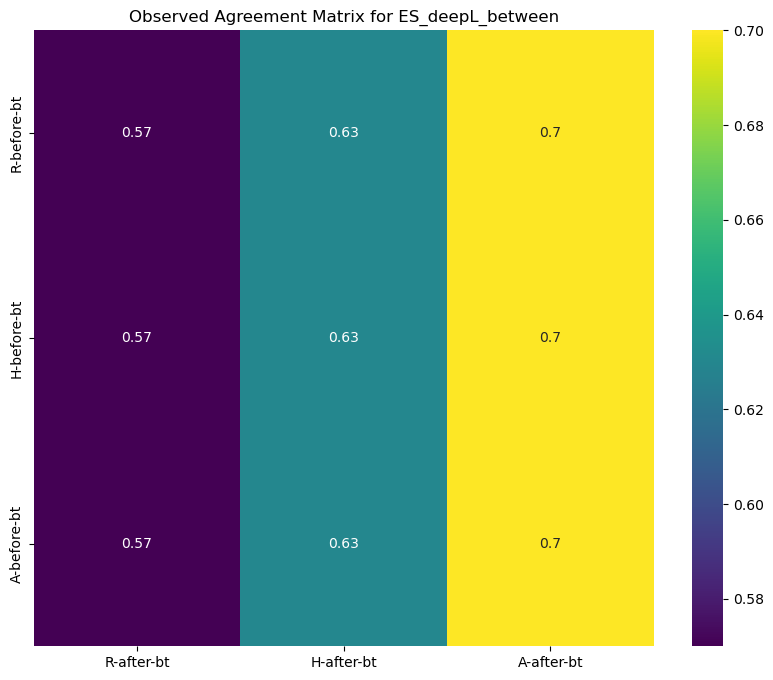

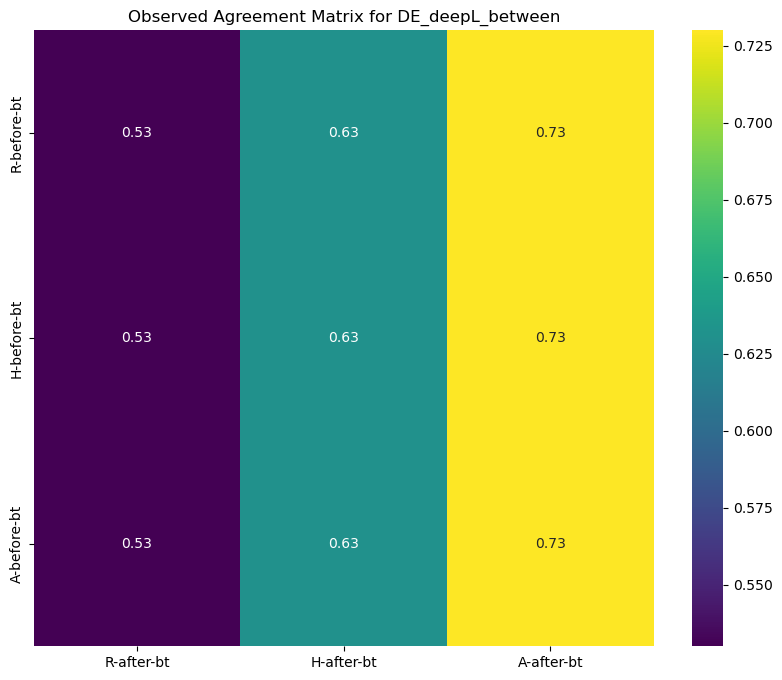

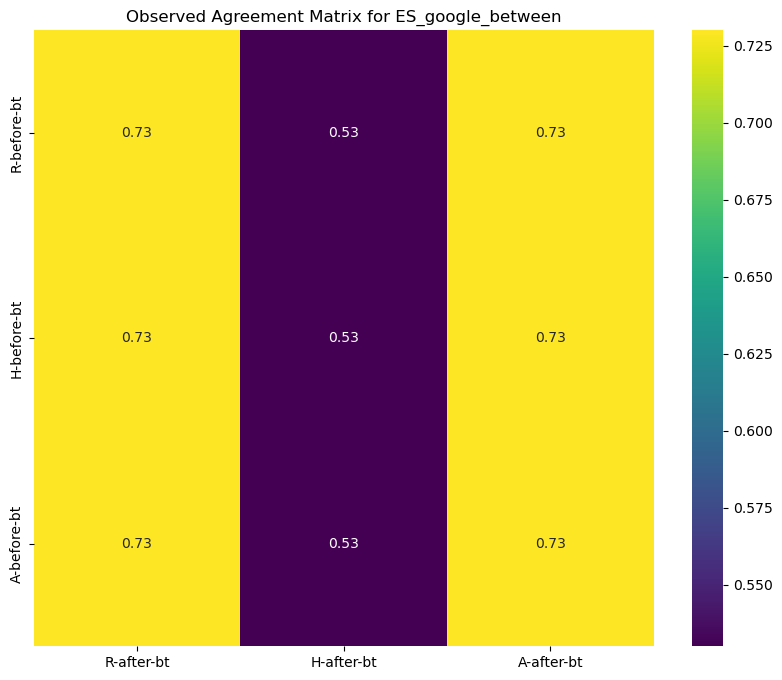

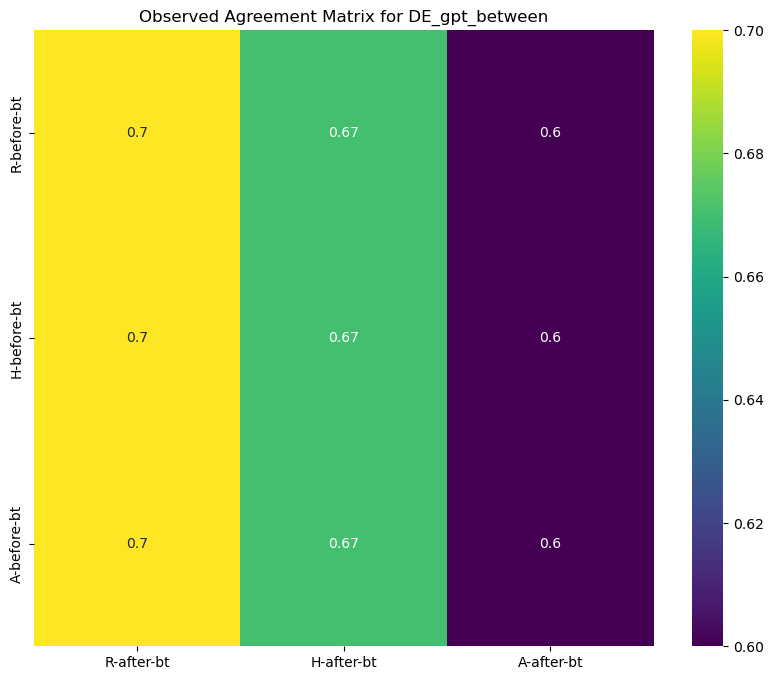

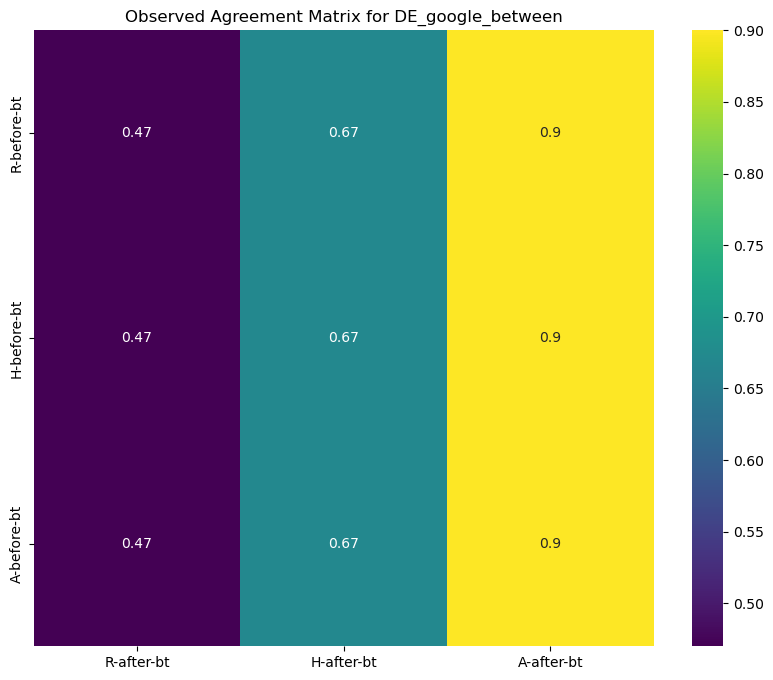

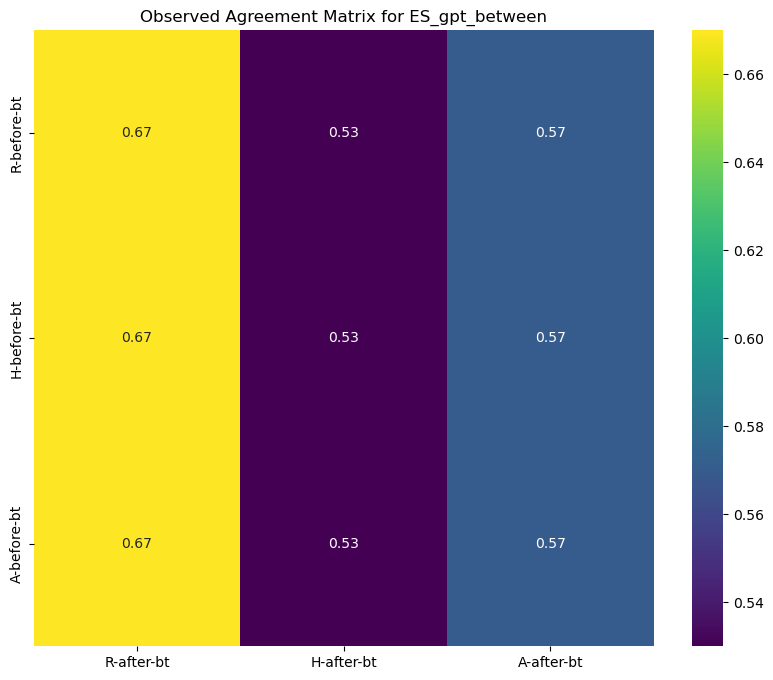

In [10]:
for name, matrix in separated_matrices.items():
    if 'between' in name:
        plt.figure(figsize=(10, 8))
        sns.heatmap(matrix, annot=True, cmap='viridis', cbar=True)
        plt.title(f'Observed Agreement Matrix for {name}')
        plt.show()


In [11]:
#Due to time constraints, the values resulting from the matrics above were manually computed for OA 